In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 396 kB/s 
     |████████████████████████████████| 448 kB 50.4 MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
import math
import copy
import gc
from tqdm import tqdm
from glob import glob
from konlpy.tag import Mecab

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [5]:
from konlpy.tag import Okt
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.io as pio
import plotly.express as px

%matplotlib inline
pio.renderers.default = 'notebook_connected'# 'colab'


In [6]:
kgm = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/db/data/n_debate/kagame.csv", encoding = "euc-kr")

In [7]:
kgm.head()

,title,date
0,증권가 주목 루머들,2022.02.07 23:18
1,스톡옵션,2022.02.07 23:06
2,카카오게임즈 실적 증권가 전망,2022.02.07 23:03
3,실적하향이다,2022.02.07 22:21
4,아름다운 조정이구먼,2022.02.07 22:05


In [8]:
def tolist(df):
  titles = list(df['title'])
  
  return titles

kgm_titles = tolist(kgm)

In [9]:
# tolist예시 tokenized_title = [r.split() for r in kgm_titles]

In [11]:
#len_by_token = [len(t) for t in tokenized_title]

In [15]:
#len_by_eumjeol = [len(s.replace(' ', '')) for s in kgm_titles]

Text(0, 0.5, 'number of titles')

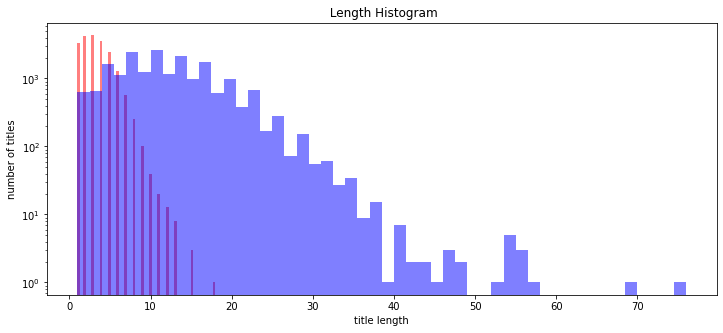

In [16]:
'''
plt.figure(figsize = (12,5))

plt.hist(len_by_token, bins = 50, alpha=0.5, color="r", label="word")
plt.hist(len_by_eumjeol, bins = 50, alpha=0.5, color="b", label="aplt.yscallphabet")

plt.yscale('log', nonposy = 'clip')
plt.title(' Length Histogram')
plt.xlabel('title length')
plt.ylabel('number of titles')
'''

In [17]:
'''
print('문장 최대 길이 : {}'.format(np.max(len_by_token)))
print('문장 최소 길이 : {}'.format(np.min(len_by_token)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(len_by_token)))
print('문장 길이 표준편타 : {:.2f}'.format(np.std(len_by_token)))
print('문장 중간 길이 : {}'.format(np.median(len_by_token)))
print('제 1사분위 길이 : {}'.format(np.percentile(len_by_token, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(len_by_token, 75)))
'''

문장 최대 길이 : 18
문장 최소 길이 : 1
문장 평균 길이 : 3.31
문장 길이 표준편타 : 1.80
문장 중간 길이 : 3.0
제 1사분위 길이 : 2.0
제 3사분위 길이 : 4.0


In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

In [10]:
okt = Okt()

In [ ]:
#kgm_titles

In [11]:
#특수 문자 제거
def del_spstr(li):
  compile = re.compile("[^ ㄱ-ㅣ가-힣]+")
  
  for i in range(len(li)):
    a = compile.sub("",li[i])
    li[i] = a
    
  return li

In [12]:
#불용어 제거
def del_stopword(li):
  stop_word = ["ㅋㅋ", "ㅋㅋㅋ", "것이다","이제","증권","병맛","",
               "는","졸","내","울"] #사용하지 않을 단어 또는 문장 추가
  li = [i for i in li if i not in stop_word]

  return li

In [13]:
def ext_noun(li):
  nouns = okt.nouns(''.join(li))
  word = [n for n in nouns if len(n)>1]

  return word

In [28]:
#new = ext_noun(kgm_titles)

In [30]:
#del_words = del_stopword(new)

In [31]:
#c = Counter(del_words)

In [32]:
'''
korean = pd.Series(del_words).value_counts().head(10)
print("kakao games word frequency top 10")
print(korean)
'''

kakao games word frequency top 10
오늘     952
게임     909
카겜     860
매수     768
카카오    760
오딘     612
개미     513
주식     481
간다     333
공매도    331
dtype: int64


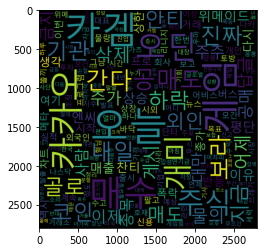

In [ ]:
'''
wc = WordCloud(font_path='/content/drive/MyDrive/Colab Notebooks/db/MALGUN.TTF', width=1400, height=1400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(c)
plt.figure()
plt.imshow(gen)
'''

In [14]:
# 기간별로 count 하는 코드
## 기간을 주별로 묶기
def to_week(df):
  df['date'] = df['date'].str.replace('.','-')
  df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M'))

  df.set_index(df['date'], inplace=True)
  week = [g for n, g in df.set_index('date').groupby(pd.Grouper(freq='W'))]

  return week

In [84]:
#kgm.set_index(kgm['date'], inplace=True)

In [88]:
#kgm = kgm.drop('date',1)

In [95]:
#week = [g for n, g in kgm.set_index('date').groupby(pd.Grouper(freq='W'))]

In [15]:
week = to_week(kgm)

In [17]:
for i in week:
  tokenized_title = [r.split() for r in tolist(i)]

In [128]:
#tokenized_title = [x for n in tokenized_title for x in n]

In [130]:
#title = del_spstr(tokenized_title)

In [134]:
#title = del_stopword(title)

In [18]:
# 여기부터 기준 주만 
standard = [r.split() for r in tolist(week[0])]

In [19]:
standard = [x for n in standard for x in n]

In [20]:
st = del_spstr(standard)

In [21]:
st = del_stopword(st)
st

['이정도로',
 '운전한다고',
 '개',
 '슈렉',
 '잡주',
 '계단식',
 '하락이라고',
 '들어봤니',
 '나무서워',
 '형들',
 '미안해',
 '우마무스메',
 '기다리는것도',
 '웃긴게',
 '신용으로',
 '질렀다',
 '카겜',
 '단기로',
 '내릴거',
 '예상하긴했는데',
 '위메이드와',
 '카켐',
 '조정때보면',
 '시비가',
 '갈리네',
 '반등주면무조건',
 '리스크관리한다',
 '다시',
 '더',
 '탔다',
 '어이',
 '주식',
 '전나게',
 '못하는',
 '색휘들아ㅋㅋ',
 '얘기하면',
 '좀들어라',
 '우끼네',
 '일도',
 '손에안잡히네',
 '밖에',
 '비가',
 '내리는줄',
 '알았는데',
 '와',
 '시초에',
 '익절하고나온게',
 '신의한수',
 '그렇게',
 '해도',
 '안',
 '팔아요',
 '엘앤에프도',
 '똑같이',
 '떨어지는거',
 '보니',
 '코인',
 '욕하고',
 '있었는데',
 '등',
 '대장주',
 '더럽게',
 '파네',
 '개투들',
 '일서까지',
 '매수금지',
 '겜주들',
 '왜그럼',
 '편안하게',
 '잘보고있는데',
 '카겜만',
 '빠지면',
 '안뺄라했는데',
 '이거',
 '왜',
 '폭락햇는지',
 '모르냐',
 '반도체로',
 '수급쏠리나',
 '앞뒤',
 '안가리고',
 '버리네',
 '놀랍다',
 '지스타',
 '시작할때',
 '나온게',
 '신의',
 '한수네',
 '도망치자',
 '참',
 '하한가가나',
 '이거',
 '추매',
 '지옥을',
 '맛볼것이다',
 '와',
 '빨리털기',
 '잘했다',
 '벌써',
 '고점에서만원빠짐',
 '오를때는',
 'ㅈ빠지게',
 '안오르더니',
 '도망쳐',
 'ㅋㅋㅋㅋ',
 '카겜은',
 '움직임이',
 '엘앤에프와',
 '비슷하구나',
 '부도냐',
 '개미만',
 '계속사네',
 '들',
 '만원',
 '대로',
 '가겠다',
 '좀만',
 '더',
 '떨구자',
 '진짜',

In [22]:
st = ext_noun(st)

In [23]:
c = Counter(st)

In [27]:
korean = pd.Series(st).value_counts().head(10)
print("kakao games word frequency top 10")
print(korean)

kakao games word frequency top 10
게임     206
오늘     189
개미     134
카카오    126
카겜     122
보라      88
만원      84
매수      79
주식      77
하락      68
dtype: int64


In [ ]:
pd.Series(st).to_csv('standard_Word_kgm.csv',index =False)

In [35]:
st = pd.read_csv("/content/standard_Word_kgm.csv")